# iminuit: fitting models to data

**Hans Dembinski** | TU Dortmund

**PyPI** https://pypi.org/project/iminuit

**Source** https://github.com/scikit-hep/iminuit

**Documentation** http://iminuit.readthedocs.org

**Latest release** v2.16.0

![](https://github.com/scikit-hep/iminuit/blob/develop/doc/_static/iminuit_logo.svg)

## Introduction

### iminuit is a frontend to the Minuit2 C++ library

- Minimize statistical cost functions with box constraints
- Compute **parameter uncertainties** under these constraints (unique)
- Robust technology from 1975 that stood the tests of time
- Minuit or Minuit2 are behind virtually every HEP analysis
- iminuit is Python frontend to Minuit2 C++ code in ROOT
    - iminuit contributed several patches to Minuit2 C++
- For history of Minuit and iminuit, see [PyHEP 2020 talk](https://github.com/hdembinski/pyhep-2020-iminuit)

### iminuit or zfit or pyhf?

- iminuit is low-level, lightweight, hackable, easy to learn, easy to extend
- Supports all kinds of fits: unbinned and binned, templates, simultaneous
- Simplicity is useful for teaching, attractive for beginners and experts
- No automation, you need to understand what you are doing
- Out of scope
    - Building statistical models: you need to write your own pdf/cdf
    - Making sophisticated limits
    - Storing likelihoods
- Where the other fitting tools shine
    - pyhf: Complex binned fits, limit setting, storing the likelihood
    - zfit: Building statistical models, automatic sampling from fitted model

## iminuit and a simple fit

A quick demo how to do a simple least-squares fit with iminuit.

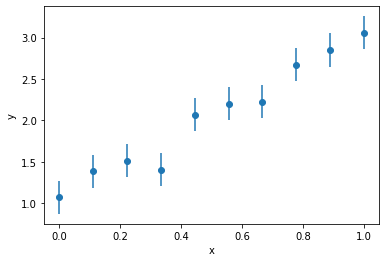

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from argparse import Namespace

# make 10 data points with scatter on y-coordinate

rng = np.random.default_rng(1)

x = np.linspace(0, 1, 10)
ye = np.ones_like(x) * 0.2
y = rng.normal(2 * x + 1, ye)

data = Namespace(x=x, y=y, ye=ye)

plt.errorbar(data.x, data.y, data.ye, fmt="o")
plt.xlabel("x")
plt.ylabel("y");

To get parameters of the line:

- Need to provide **model** and **cost function**
- Model predicts $y = f(x; \vec p)$ for some parameters $\vec p$
- Cost function computes some "distance" between model and observations

- No need to write cost function, `iminuit.cost` contains all common ones
- Model can be any vectorized Python function

In [33]:
from iminuit import Minuit, cost

# line model
def model(x, a, b):
    return a + b * x

# see docs for iminuit.cost to pick correct cost function
lsq = cost.LeastSquares(data.x, data.y, data.ye, model)

# - initialize Minuit object by passing cost function
# - Minuit uses a local minimizer, we need to set starting values
m = Minuit(lsq, a=0, b=0)
m

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.0,0.1,,,,,
1,b,0.0,0.1,,,,,


- iminuit detected that `lsq` has parameters named `a` and `b`
- `Minuit` object
  - Represents current state of fit
  - Main way to interact with fitting process

In [34]:
# call Migrad minimizer (for other options, see docs)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (chi2/ndof = 0.5)    │              Nfcn = 34               │
│ EDM = 2.65e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.05    │   0.12    │            │            │         │         │       │
│ 1 │ b    │   1.99    │   0.20    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │  0.0138 -0.0196 │
│ b │ -0.0196  0.0393 │
└───┴─────────────────┘

- Printed values and errors are rounded to **PDG rounding rules**
- *Hesse error*: standard symmetric error estimate (based on asymptotic theory)
- *Minos error*: standard asymmetric error estimate (based on likelihood profiling)
- *EDM*: estimated distance to minimum, must be smaller than "Goal"; shows that Migrad converged
- *Nfcn*: How many function calls were used by Migrad
- *Pos. def.*: Hessian matrix (matrix of second derivatives) is positive definite; must be for valid minimum
- *chi2/ndof*: Computed at no additional cost whenever possible if iminuit's cost functions are used

See docs for more details on Hesse, Minos, EDM.

Output by parts:

In [35]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.05,0.12,,,,,
1,b,1.99,0.20,,,,,


In [36]:
m.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (chi2/ndof = 0.5)    │              Nfcn = 34               │
│ EDM = 2.65e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [37]:
m.covariance

,a,b
a,0.0138,-0.0196 (-0.843)
b,-0.0196 (-0.843),0.0393


In [38]:
# Minos Errors are not automatically computed, you need to run *Minos* explicitly
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (chi2/ndof = 0.5)    │              Nfcn = 60               │
│ EDM = 2.65e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.05    │   0.12    │   -0.12    │    0.12    │         │         │       │
│ 1 │ b    │   1.99    │   0.20    │   -0.20    │    0.20    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.12   │   0.12    │   -0.2    │    0.2    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │  0.0138 -0.0196 │
│ b │ -0.0196  0.0393 │
└───┴─────────────────┘

- Hesse and Minos errors identical in this case, because asymptotic theory is correct here
- Prefer reporting Hesse errors unless Minos errors differ a lot

In [39]:
# Minos errors can be read-out like this

me = m.merrors["a"] # returns a data struct with many fields

me.name, me.is_valid, me.lower, me.upper

('a', True, -0.11755076272896135, 0.11755076272914197)

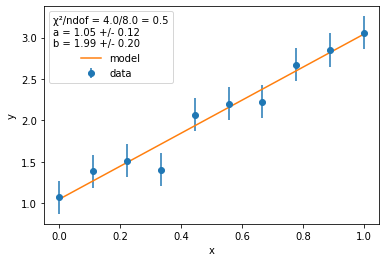

In [40]:
# draw data and fitted model

plt.errorbar(data.x, data.y, data.ye, fmt="o", label="data")
plt.plot(data.x, model(data.x, *m.values[:]), label="model")

title = [
    f"χ²/ndof = {m.fval:.1f}/{m.ndof} = {m.fval/m.ndof:.1f}",
]
for par in m.parameters:
    title.append(
        f"{par} = {m.values[par]:.2f} +/- {m.errors[par]:.2f}"
    )

plt.legend(title="\n".join(title))
plt.xlabel("x")
plt.ylabel("y");

## Why fits fail and how to fix it

#### Starting values far away

- Fits can fail when starting values are poor
- Numerical reason: cost function uses log(pdf) and pdf may return 0 when data are far away from prediction

In [41]:
# numba_stats has faster versions of statistical distributions in scipy.stats 
from numba_stats import norm

norm.pdf([1, 10, 100, 1000], 0.0, 0.1)

array([7.69459863e-22, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

- How to fix this
  - Find better starting values, e.g. use values from simulation
  - Binned fits tend to be more robust than unbinned fits
  - Use least-squares fit followed by maximum-likelihood fit, least-squares is more robust

In [42]:
lsq(1e100, 1e100)

5.879629629629629e+202

In [120]:
# Generate signal and background mixture

rng = np.random.default_rng(1)

s = rng.normal(0.5, 0.1, size=1000)
b = rng.exponential(0.8, size=2000)
x = np.append(s, b)
x = x[x < 1]

data = Namespace(s=s, b=b, x=x, range=(0, 1))

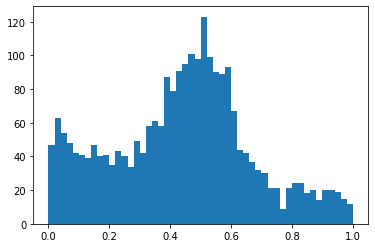

In [121]:
# Bin and draw data

import boost_histogram as bh

data.h = bh.Histogram(bh.axis.Regular(50, 0, 1))
data.h.fill(data.x)

plt.stairs(data.h.values(), data.h.axes[0].edges, fill=True);

In [141]:
cost.ExtendedBinnedNLL?

Init signature:
cost.ExtendedBinnedNLL(
    n: Sequence,
    xe: Sequence,
    scaled_cdf: Callable,
    verbose: int = 0,
)
Docstring:     
Binned extended negative log-likelihood.

Use this if shape and normalization of the fitted PDF are of interest and the data is
binned. This cost function works with normal and weighted histograms. The histogram
can be one- or multi-dimensional.

The cost function works for both weighted data. The cost function assumes that
the weights are independent of the data. This is not the case for sWeights, and
the uncertaintes for results obtained with sWeights will only be approximately
correct, see C. Langenbruch, Eur.Phys.J.C 82 (2022) 5, 393.

The cost function has a minimum value that is asymptotically chi2-distributed. It is
constructed from the log-likelihood assuming a poisson distribution and using the
saturated model as a reference.
Init docstring:
Initialize cost function with data and model.

Parameters
----------
n : array-like
    Histogram 

In [145]:
from numba_stats import truncnorm, truncexpon

# scaled cdf
def model(x, ns, mu, sigma, nb, slope):
    s = ns * truncnorm.cdf(x, *data.range, mu, sigma)
    b = nb * truncexpon.cdf(x, *data.range, 0, slope)
    return s + b

nll = cost.ExtendedBinnedNLL(data.h.values(), data.h.axes[0].edges, model)

m = Minuit(nll, ns=1, mu=5, sigma=0.1, nb=1, slope=1)
m.migrad()

/usr/local/lib/python3.8/site-packages/iminuit/cost.py:990: RuntimeWarning: invalid value encountered in less
  d[d < 0] = 0


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 441              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │     1     │    nan    │            │            │         │         │       │
│ 1 │ mu    │     5     │    nan    │            │            │         │         │       │
│ 2 │ sigma │   1e-1    │    nan    │            │            │         │         │       │
│ 3 │ nb    │     1     │    nan    │            │            │         │         │       │
│ 4 │ slope │     1     │    nan    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │    ns    mu sigma    nb slope │
├───────┼───────────────────────────────┤
│    ns │   nan   nan   nan   nan   nan │
│    mu │   nan   nan   nan   nan   nan │
│ sigma │   nan   nan   nan   nan   nan │
│    nb │   nan   nan   nan   nan   nan │
│ slope │   nan   nan   nan   nan   nan │
└───────┴───────────────────────────────┘

In [152]:
nll(1, 5, 0.1, 1, 1)

nan

#### Model parameters outside mathematical domain

* Minuit supports can place limits on parameters, this is important
* Examples
  - σ parameter of normal distribution must be positive
  - μ parameter of Poisson distribution must be non-negative
* If you do not place limits on such parameters, fit is likely to fail

In [153]:
m = Minuit(nll, ns=1, mu=0.5, sigma=0.1, nb=1, slope=1)

m.limits["mu"] = (0, 1)
m.limits["ns", "nb", "sigma", "slope"] = (0, None)

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 203.9 (chi2/ndof = 4.5)    │              Nfcn = 411              │
│ EDM = 1.41e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │   919.1   │    2.0    │            │            │    0    │         │       │
│ 1 │ mu    │   0.484   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma │   0.094   │   0.004   │            │            │    0    │         │       │
│ 3 │ nb    │ 1.5179e3  │ 0.0020e3  │            │            │    0    │         │       │
│ 4 │ slope │ 1.3171e3  │ 0.0020e3  │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │      3.99 -5.53e-05  0.000141  -0.00482  1.86e-07 │
│    mu │ -5.53e-05  2.47e-05 -5.01e-06  3.36e-05 -3.24e-08 │
│ sigma │  0.000141 -5.01e-06  1.68e-05 -8.58e-05  1.19e-08 │
│    nb │  -0.00482  3.36e-05 -8.58e-05      3.99 -1.13e-07 │
│ slope │  1.86e-07 -3.24e-08  1.19e-08 -1.13e-07         4 │
└───────┴───────────────────────────────────────────────────┘

* Fit converged but chi2/ndof looks bad

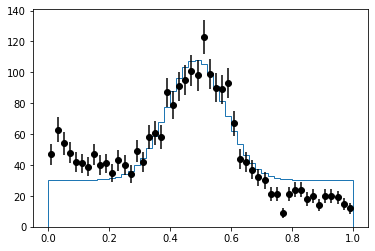

In [156]:
# draw model and data

n = data.h.values()
ne = data.h.variances() ** 0.5
xe = data.h.axes[0].edges
cx = data.h.axes[0].centers

plt.errorbar(cx, n, ne, fmt="ok")

scaled_cdf = model(xe, *m.values)
nm = np.diff(scaled_cdf)

plt.stairs(nm, xe);

* Fit converged to state where slope is "infinite" and background flat
* Fix this by making limit on slope more tight

In [157]:
m.limits["slope"] = (0, 2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.6 (chi2/ndof = 0.9)     │              Nfcn = 544              │
│ EDM = 3.19e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    950    │    50     │            │            │    0    │         │       │
│ 1 │ mu    │   0.498   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma │   0.093   │   0.005   │            │            │    0    │         │       │
│ 3 │ nb    │  1.49e3   │  0.05e3   │            │            │    0    │         │       │
│ 4 │ slope │   0.81    │   0.07    │            │            │    0    │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │  2.45e+03   -0.0228     0.108  -1.5e+03    -0.716 │
│    mu │   -0.0228  2.26e-05 -2.86e-06    0.0228 -6.01e-05 │
│ sigma │     0.108 -2.86e-06  2.02e-05    -0.108 -4.48e-05 │
│    nb │  -1.5e+03    0.0228    -0.108  2.99e+03     0.716 │
│ slope │    -0.716 -6.01e-05 -4.48e-05     0.716    0.0045 │
└───────┴───────────────────────────────────────────────────┘

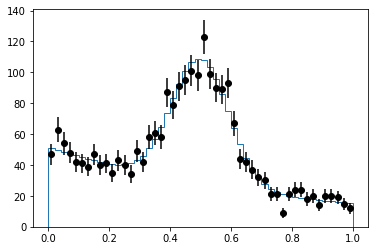

In [159]:
# draw model and data again

n = data.h.values()
ne = data.h.variances() ** 0.5
xe = data.h.axes[0].edges
cx = data.h.axes[0].centers

plt.errorbar(cx, n, ne, fmt="ok")

scaled_cdf = model(xe, *m.values)
nm = np.diff(scaled_cdf)

plt.stairs(nm, xe);

#### Model parameters are not constrained by data

- Data may not be precise enough to constrain all model parameters
- Leads to parameters that are perfectly (anti)correlated

In [200]:
# add another background component to model
def model(x, ns, mu, sigma, nb1, slope1, nb2, slope2):
    s = ns * truncnorm.cdf(x, *data.range, mu, sigma)
    b1 = nb1 * truncexpon.cdf(x, *data.range, 0, slope1)
    b2 = nb2 * truncexpon.cdf(x, *data.range, 0, slope2)
    return s + b1 + b2

nll = cost.ExtendedBinnedNLL(data.h.values(), data.h.axes[0].edges, model)

m = Minuit(nll, ns=1, mu=0.5, sigma=0.1, nb1=1, slope1=1, nb2=1, slope2=0.1)
m.limits["ns", "nb1", "nb2", "sigma"] = (0, None)
m.limits["mu"] = (0, 1)
m.limits["slope1", "slope2"] = (0, 2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 694.8 (chi2/ndof = 16.2)   │             Nfcn = 1118              │
│ EDM = 3.37e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns     │ 4.8263e-9 │ 0.0000e-9 │            │            │    0    │         │       │
│ 1 │ mu     │ 8.5436e-1 │ 0.0000e-1 │            │            │    0    │    1    │       │
│ 2 │ sigma  │ 1.8477e5  │ 0.0000e5  │            │            │    0    │         │       │
│ 3 │ nb1    │ 7.7481e2  │ 0.0000e2  │            │            │    0    │         │       │
│ 4 │ slope1 │  1.3316   │  0.0000   │            │            │    0    │    2    │       │
│ 5 │ nb2    │ 1.6622e3  │ 0.0000e3  │            │            │    0    │         │       │
│ 6 │ slope2 │  1.3317   │  0.0000   │            │            │    0    │    2    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [201]:
# fix nb2 to 0, but forget to fix slope2
m.values = [p.value for p in m.init_params]
m.values["nb2"] = 0
m.fixed["nb2"] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.6 (chi2/ndof = 0.9)     │             Nfcn = 1808              │
│ EDM = 3.68e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns     │ 9.5004e2  │ 0.0000e2  │            │            │    0    │         │       │
│ 1 │ mu     │ 4.9776e-1 │ 0.0000e-1 │            │            │    0    │    1    │       │
│ 2 │ sigma  │ 9.3454e-2 │ 0.0000e-2 │            │            │    0    │         │       │
│ 3 │ nb1    │  1.487e3  │  0.000e3  │            │            │    0    │         │       │
│ 4 │ slope1 │ 8.1152e-1 │ 0.0000e-1 │            │            │    0    │    2    │       │
│ 5 │ nb2    │     0     │     0     │            │            │    0    │         │  yes  │
│ 6 │ slope2 │   1e-1    │   0e-1    │            │            │    0    │    2    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [202]:
# slope2 is not constrained by data now, since corresponding amplitude is zero
# fixing slope2 resolve the issue
m.values = [p.value for p in m.init_params]
m.fixed["slope2"] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.56 (chi2/ndof = 0.9)    │             Nfcn = 2136              │
│ EDM = 2.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns     │    950    │    50     │            │            │    0    │         │       │
│ 1 │ mu     │   0.498   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma  │   0.093   │   0.005   │            │            │    0    │         │       │
│ 3 │ nb1    │  1.49e3   │  0.05e3   │            │            │    0    │         │       │
│ 4 │ slope1 │   0.81    │   0.07    │            │            │    0    │    2    │       │
│ 5 │ nb2    │     1     │     0     │            │            │    0    │         │  yes  │
│ 6 │ slope2 │   1e-1    │   0e-1    │            │            │    0    │    2    │  yes  │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────┐
│        │        ns        mu     sigma       nb1    slope1       nb2    slope2 │
├────────┼───────────────────────────────────────────────────────────────────────┤
│     ns │  2.45e+03   -0.0228     0.108  -1.5e+03    -0.716         0         0 │
│     mu │   -0.0228  2.26e-05 -2.87e-06    0.0229 -6.05e-05         0         0 │
│  sigma │     0.108 -2.87e-06  2.02e-05    -0.108 -4.48e-05         0         0 │
│    nb1 │  -1.5e+03    0.0229    -0.108  2.99e+03     0.715         0         0 │
│ slope1 │    -0.716 -6.05e-05 -4.48e-05     0.715   0.00454         0         0 │
│    nb2 │         0         0         0         0         0         0         0 │
│ slope2 │         0         0         0         0         0         0         0 │
└────────┴───────────────────────────────────────────────────────────────────────┘

In [ ]:
TODO
- BarlowBeeston
- Fitting widget

In [ ]:
# signal window is roughly 0.3 to 0.7, let's mask that out
cx = 0.5 * (xe[1:] + xe[:-1]) # compute bin centers

cost.mask = (cx < 0.3) | (0.7 < cx)

cost.verbose = 0 # turn verbosity off again, this fit should not cause trouble

m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_lambd=(0, None),
           limit_sigma=(0, None))

# fix signal parameters for next fit and set signal amplitude to zero
m.fixed[:3] = True
m.values["ns"] = 0

m.migrad()

In [ ]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

Much better! We now unmask the signal, fix the background parameters and only fit the signal.

In [ ]:
cost.mask = None
m.fixed[:] = False
m.fixed["nb"] = True
m.fixed["lambd"] = True
m.values["ns"] = 1
m.migrad()

In [ ]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

This looks great! To wrap things up, we let Minuit optimize everything together to get the final values and uncertainties.

In [ ]:
m.fixed[:] = False
m.migrad()

The values changed a bit and the uncertaintes of the signal parameters became larger. That is expected unless the parameters are independent.

In [ ]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

🎉🎉🎉

### Final note: set limits appropriately

We could have gotten the good result right away by setting appropriate limits on all parameters.

In [ ]:
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_ns=(0, None),
           limit_nb=(0, None),  
           limit_mu=(0.4, 0.6),
           limit_lambd=(0, 2),
           limit_sigma=(0, 0.2))
m.migrad()

In [ ]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

As you can see, the result is the same with and without limits within the precision that matters.

Some sources (including the Minuit2 user guide) warn about setting limits carelessly. That advice is correct, but unless a parameter converges to a value very close to a limit boundary, the result with and without limits will be effectively the same. For the parameter value itself, this is a guaranteed proven property. Only the parameter uncertainty may be off.

## Bonus: iminuit and resample

In [ ]:
from resample import bootstrap

cost.n = np.histogram(x, bins=30, range=(0, 1))[0]
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_ns=(0, None),
           limit_nb=(0, None),  
           limit_mu=(0.4, 0.6),
           limit_lambd=(0, 2),
           limit_sigma=(0, 0.2))
m.migrad()
print(f"nfcn for original fit = {m.fmin.nfcn}")

errors = m.errors[:]
nfcn = m.fmin.nfcn

rng = np.random.default_rng(1)
b_value = []
b_nfcn = []
for i, b_sample in enumerate(bootstrap.resample(x, size=50,
                                                random_state=rng)):
    cost.n = np.histogram(b_sample, bins=30, range=(0, 1))[0]
    m.migrad()
    print(f"nfcn for fit of b_sample[{i}] = {m.fmin.nfcn}")
    assert m.valid
    b_value.append(m.values[:])
    b_nfcn.append(m.fmin.nfcn)

Migrad remembers previous fit result and converges quickly to nearby bootstrapped result.

In [ ]:
plt.axvline(nfcn, color="C0", label="original")
plt.hist(b_nfcn, color="C1", label="bootstrapped")
plt.xlabel("number of likelihood evaluations")
plt.legend();

In [ ]:
b_cov = np.cov(np.transpose(b_value))
b_errors = np.diag(b_cov) ** 0.5

height = 0.35
i = np.arange(5)
plt.barh(i - height/2, errors, height, label="Minuit")
plt.barh(i + height/2, b_errors, height, label="bootstrap")
plt.semilogx()
plt.yticks(i, m.parameters)
plt.xlabel("uncertainty estimate")
plt.legend();

## Future plans

* Replace Cython bindings with pybind11 bindings
    * Cython is lagging behind C++ features
    * iminuit requires lots of workarounds because of missing features in Cython
    * pybind11 is not a separate code generator, just C++
* Support unicode parameters
* Support pickling of Minuit object

## PS: Check out more great iminuit tutorials

https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

* How Hesse and Minos really work, which to use when, and is Minos really better? *The answer may surprise you.*
* How to use the new cost functions
* How to combine automatic differentation with JAX with iminuit
* How to use numba to accelerate cost functions